In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

import time
import pandas as pd

import sys
sys.path.append("../ddsl_load_tester")

import ddsl_load_tester as load_tester

# Getting Current Status

In [2]:
load_tester.get_current_stats()

{'current_response_time_percentile_50': 54.172515869140625,
 'current_response_time_percentile_95': 280,
 'errors': [],
 'fail_ratio': 0.0,
 'state': 'running',
 'stats': [{'avg_content_length': 4.0,
   'avg_response_time': 96.13980039506511,
   'current_rps': 14.3,
   'max_response_time': 431.1709403991699,
   'median_response_time': 67.06023216247559,
   'method': 'GET',
   'min_response_time': 23.005247116088867,
   'name': '/function/pyfibo/',
   'num_failures': 0,
   'num_requests': 233},
  {'avg_content_length': 4.0,
   'avg_response_time': 96.13980039506511,
   'current_rps': 14.3,
   'max_response_time': 431.1709403991699,
   'median_response_time': 67.06023216247559,
   'method': None,
   'min_response_time': 23.005247116088867,
   'name': 'Total',
   'num_failures': 0,
   'num_requests': 233}],
 'total_rps': 14.3,
 'user_count': 100}

# Running a Sequence

In [3]:
from tqdm.auto import tqdm
tqdm.pandas()

loop_timer = load_tester.TimerClass()
total_timer = load_tester.TimerClass()

user_sequence = [50,100,500,1000,1000,1000,500,100,50]
lt = load_tester.DdslLoadTester(hatch_rate=1000, temp_stat_max_len=5, base='http://localhost:8089/')
lt.change_count(user_sequence[0])
lt.start_capturing()

loop_time_in_secs = load_tester.get_loop_time_in_secs('10s')

loop_timer.tic()
total_timer.tic()

results = None
for i in tqdm(range(len(user_sequence))):
    user_count = user_sequence[i]
    lt.change_count(user_count)
    
    time.sleep(loop_time_in_secs - loop_timer.toc())
    
    loop_timer.tic()
    
    result = lt.get_all_stats()
    df_result = pd.DataFrame(data=result)
    
    if results is None:
        results = df_result
    else:
        results = results.append(df_result)
    
lt.stop_test()

results, filename = lt.prepare_results_from_df(results)

results.head()

,time,current_response_time_percentile_50,current_response_time_percentile_95,fail_ratio,total_rps,user_count,avg_response_time,current_rps,max_response_time,median_response_time,min_response_time,num_failures,num_requests,elapsed,elapsed_min
0,1.556893e+09,54.172516,280.000000,0.0,14.3,100,96.139800,14.3,431.17094,67.060232,23.005247,0,233,0.000000,0.000000
1,1.556893e+09,26.038170,91.372728,0.0,15.1,50,91.804550,15.1,431.17094,65.026283,23.005247,0,253,1.974996,0.032917
2,1.556893e+09,26.014090,74.340343,0.0,15.0,50,89.664631,15.0,431.17094,64.054728,23.005247,0,263,3.977165,0.066286
3,1.556893e+09,26.006937,82.383871,0.0,11.1,50,86.462932,11.1,431.17094,61.353207,23.005247,0,281,5.984592,0.099743
4,1.556893e+09,26.006937,82.383871,0.0,11.1,50,86.462932,11.1,431.17094,61.353207,23.005247,0,281,7.979686,0.132995


# Showing Stats For Each Loop

In [4]:
result

{'time': [1556893455.5122523,
  1556893457.5276916,
  1556893459.516725,
  1556893461.521768,
  1556893463.5200727],
 'current_response_time_percentile_50': [28.674602508544922,
  28.119564056396484,
  28.119564056396484,
  27.900218963623047,
  27.900218963623047],
 'current_response_time_percentile_95': [94.2540168762207,
  95.72100639343262,
  95.72100639343262,
  94.02608871459961,
  94.02608871459961],
 'fail_ratio': [0.0, 0.0, 0.0, 0.0, 0.0],
 'total_rps': [39.8, 16.8, 16.8, 11.8, 11.8],
 'user_count': [100, 50, 50, 50, 50],
 'avg_response_time': [261.60687242780585,
  260.1586636211012,
  260.1586636211012,
  259.08134592694427,
  259.08134592694427],
 'current_rps': [39.8, 16.8, 16.8, 11.8, 11.8],
 'max_response_time': [2004.8556327819824,
  2004.8556327819824,
  2004.8556327819824,
  2004.8556327819824,
  2004.8556327819824],
 'median_response_time': [120, 120, 120, 110, 110],
 'min_response_time': [21.972179412841797,
  21.972179412841797,
  21.972179412841797,
  21.972179412

# Plotting The Sequence Results

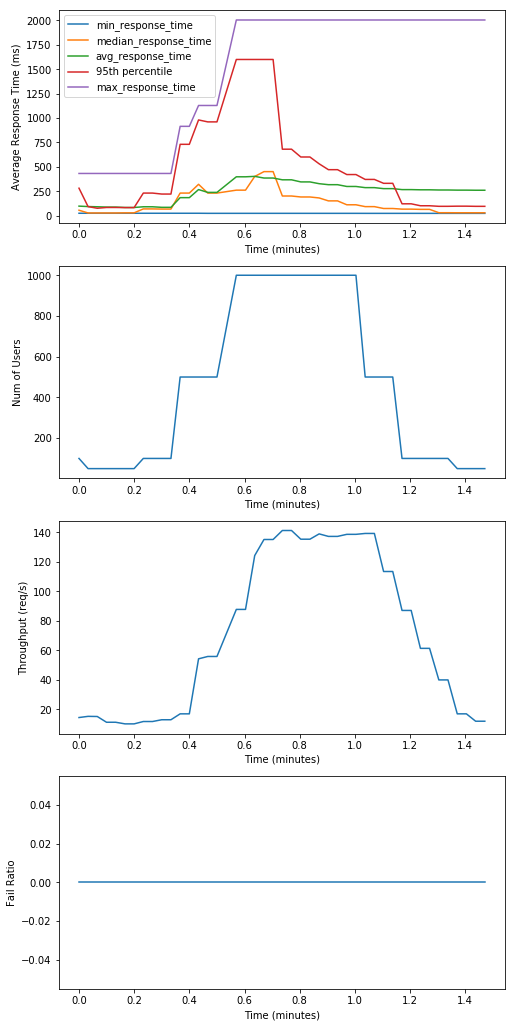

In [5]:
res = results

import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8,18))
plt.subplot(411)
plt.plot(res['elapsed_min'], res['min_response_time'], label='min_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_50'], label='median_response_time')
plt.plot(res['elapsed_min'], res['avg_response_time'], label='avg_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_95'], label='95th percentile')
plt.plot(res['elapsed_min'], res['max_response_time'], label='max_response_time')

plt.xlabel('Time (minutes)')
plt.ylabel('Average Response Time (ms)')
plt.legend()

plt.subplot(412)
plt.plot(res['elapsed_min'], res['user_count'])
plt.xlabel('Time (minutes)')
plt.ylabel('Num of Users')

plt.subplot(413)
plt.plot(res['elapsed_min'], res['total_rps'])
plt.xlabel('Time (minutes)')
plt.ylabel('Throughput (req/s)')

plt.subplot(414)
plt.plot(res['elapsed_min'], res['fail_ratio'])
plt.xlabel('Time (minutes)')
plt.ylabel('Fail Ratio')

filename = filename.replace('.csv', '')
plt.savefig(filename + '.png', dpi=300)
plt.savefig(filename + '.pdf')
plt.show()

# Testing with Custom Sensing Function

In case you need another sensing functionality (for example you also want to measure the replica count or network latency) along with other information, you can override the `custom_sensing()` function in the object.

In [6]:
def custom_sensing():
    import random
    return {'random':random.random()}

lt.custom_sensing = custom_sensing
# Testing the function
lt.custom_sensing()

{'random': 0.570523256206516}

In [7]:
from tqdm.auto import tqdm
tqdm.pandas()

loop_timer = load_tester.TimerClass()
total_timer = load_tester.TimerClass()

user_sequence = [50,100,500,1000,1000,1000,500,100,50]
lt = load_tester.DdslLoadTester(hatch_rate=1000, temp_stat_max_len=5, base='http://localhost:8089/')
lt.custom_sensing = custom_sensing
lt.change_count(user_sequence[0])
lt.start_capturing()

loop_time_in_secs = load_tester.get_loop_time_in_secs('10s')

loop_timer.tic()
total_timer.tic()

results = None
for i in tqdm(range(len(user_sequence))):
    user_count = user_sequence[i]
    lt.change_count(user_count)
    
    time.sleep(loop_time_in_secs - loop_timer.toc())
    
    loop_timer.tic()
    
    result = lt.get_all_stats()
    df_result = pd.DataFrame(data=result)
        
    if results is None:
        results = df_result
    else:
        results = results.append(df_result)
    
lt.stop_test()

results, filename = lt.prepare_results_from_df(results)

results.head()

,time,current_response_time_percentile_50,current_response_time_percentile_95,fail_ratio,total_rps,user_count,avg_response_time,current_rps,max_response_time,median_response_time,min_response_time,num_failures,num_requests,custom_random,elapsed,elapsed_min
0,1.556893e+09,120.000000,230.0,0.0,0.000000,50,122.728400,0.000000,246.101856,120.000000,50.598621,0,50,0.101528,0.000000,0.000000
1,1.556893e+09,120.000000,230.0,0.0,0.000000,50,122.728400,0.000000,246.101856,120.000000,50.598621,0,50,0.420778,2.000142,0.033336
2,1.556893e+09,120.000000,230.0,0.0,0.000000,50,122.728400,0.000000,246.101856,120.000000,50.598621,0,50,0.514926,3.997733,0.066629
3,1.556893e+09,82.220316,200.0,0.0,8.333333,50,89.136543,8.333333,246.101856,72.951317,23.376465,0,83,0.697783,6.005076,0.100085
0,1.556893e+09,65.932751,200.0,0.0,9.250000,50,79.517384,9.250000,246.101856,65.932751,23.376465,0,100,0.628278,8.016455,0.133608


Text(0, 0.5, 'Custom Value')

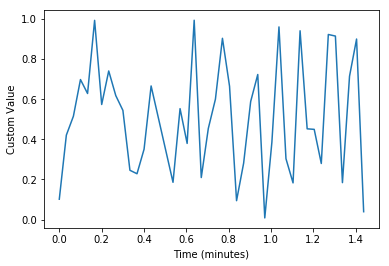

In [8]:
res = results

plt.plot(res['elapsed_min'], res['custom_random'])
plt.xlabel('Time (minutes)')
plt.ylabel('Custom Value')